In [2]:
# 참고 https://www.kaggle.com/code/balraj98/yolo-v5-car-object-detection/notebook
import os, time, random 
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%%time #전체 셀 시간 인쇄

!git clone https://github.com/ultralytics/yolov5  # Yolov5 github 레포지토리 clone
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # 필요한 모듈 설치
!cp yolov5/requirements.txt ./

fatal: destination path 'yolov5' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
cvxpy 1.3.0 requires setuptools<=64.0.2, but you have setuptools 67.6.0 which is incompatible.
CPU times: user 210 ms, sys: 77.6 ms, total: 288 ms
Wall time: 20.8 s


In [5]:
!pip uninstall imgaug
!pip install imgaug==0.4.0

Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Would remove:
    /usr/local/lib/python3.9/dist-packages/imgaug-0.4.0.dist-info/*
    /usr/local/lib/python3.9/dist-packages/imgaug/*
Proceed (Y/n)? Y
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 KB 23.9 MB/s eta 0:00:00


In [6]:
!cp yolov5/requirements.txt ./ # 필요한 모듈 다시 설치

In [8]:
from google.colab import drive
drive.mount('/gdrive') # 구글 드라이브를 gdrive 폴더에 연결

Mounted at /gdrive


In [9]:
!unzip --q "/gdrive/MyDrive/Colab Notebooks/car.zip" -d "/content/dataset"  # 압축해제 후 /content/dataset 에 넣기

Archive:  /gdrive/MyDrive/Colab Notebooks/car.zip
  inflating: /content/dataset/data/sample_submission.csv  
  inflating: /content/dataset/data/testing_images/vid_5_25100.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25120.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25140.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25160.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25180.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25200.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25220.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25240.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_25260.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_26320.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_26400.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_26420.jpg  
  inflating: /content/dataset/data/testing_images/vid_5_26560.jpg  
  infla

In [10]:
img_h, img_w, num_channels = (380, 676, 3)
df = pd.read_csv('/content/dataset/data/train_solution_bounding_boxes (1).csv')
df.rename(columns={'image':'image_id'}, inplace=True) # 열 이름 바꾸고 데이터 추가하고 이미지 조정하기
df['image_id'] = df['image_id'].apply(lambda x: x.split('.')[0])
df['x_center'] = (df['xmin'] + df['xmax'])/2
df['y_center'] = (df['ymin'] + df['ymax'])/2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']
df['classes'] = 0
df['x_center'] = df['x_center']/img_w
df['w'] = df['w']/img_w
df['y_center'] = df['y_center']/img_h
df['h'] = df['h']/img_h
df.head()

,image_id,xmin,ymin,xmax,ymax,x_center,y_center,w,h,classes
0,vid_4_1000,281.259045,187.035071,327.727931,223.225547,0.450434,0.539817,0.068741,0.095238,0
1,vid_4_10000,15.163531,187.035071,120.329957,236.430180,0.100217,0.557191,0.155572,0.129987,0
2,vid_4_10040,239.192475,176.764801,361.968162,236.430180,0.444645,0.543678,0.181621,0.157014,0
3,vid_4_10020,496.483358,172.363256,630.020260,231.539575,0.833213,0.531451,0.197540,0.155727,0
4,vid_4_10060,16.630970,186.546010,132.558611,238.386422,0.110347,0.559122,0.171491,0.136422,0


In [12]:
index = list(set(df.image_id))
image = random.choice(index)
print("Image ID: %s"%(image))
img = cv2.imread(f'/content/dataset/data/training_images/{image}.jpg')
img.shape # 랜덤하게 데이터 아이디와 크기 확인해보기

Image ID: vid_4_17540


(380, 676, 3)

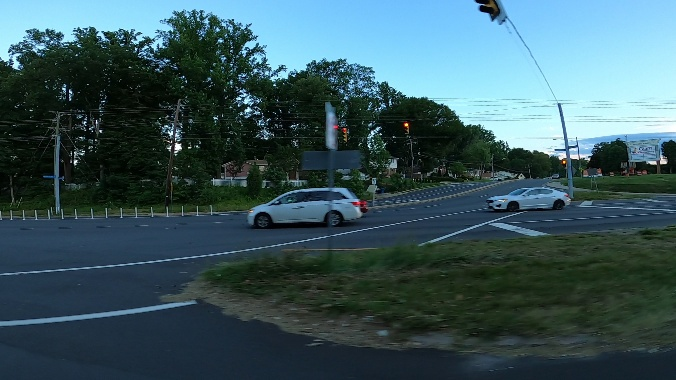

In [28]:
image = random.choice(index)
Image(filename=f'/content/dataset/data/training_images/{image}.jpg',width=600)# 아무 이미지 출력해보기

In [15]:
# 훈련 시작

source = 'training_images'
if True:
    for fold in [0]:
        val_index = index[len(index)*fold//5:len(index)*(fold+1)//5] #?
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'  # 이름이 있으면 val2017에 저장 
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save): # /tmp/convertor/fold0/labels/train2017 또는 /val2017 여기에 파일이 없으면
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save) # 파일 만들기
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:  # 텍스트 파일 열어서 읽어오기
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/dataset/data/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name)) # shutil을 이용해 파일 복사

  0%|          | 0/355 [00:00<?, ?it/s]

In [51]:
#!python /content/yolov5/train.py --batch 2 --epochs 1 --data ../input/yolov5-config/car.yaml --cfg ../input/yolov5-config/yolov5x.yaml --name yolov5x_fold0_new

In [32]:
# 예측하기
!python yolov5/detect.py --weights yolov5/yolov5s.pt --img 676 --conf 0.4 --source /content/dataset/data/testing_images


detect: weights=['yolov5/yolov5s.pt'], source=/content/dataset/data/testing_images, data=yolov5/data/coco128.yaml, imgsz=[676, 676], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-120-g3e55763 Python-3.9.16 torch-1.13.1+cu116 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
WARNING ⚠️ --img-size [676, 676] must be multiple of max stride 32, updating to [704, 704]
image 1/175 /content/dataset/data/testing_images/vid_5_25100.jpg: 416x704 (no detections), 374.3ms
image 2/175 /content/dataset/data/testing_images/vid_5_25120.jpg: 416x704 (no detections), 315.1ms
image 3/175 /content/dataset/data/testing_images/vid_5_25140.jpg: 416x704 (

In [37]:
predicted_files = []
for (dirpath, dirnames, filenames) in os.walk("yolov5/runs/detect/exp2"):
    predicted_files.extend(filenames)

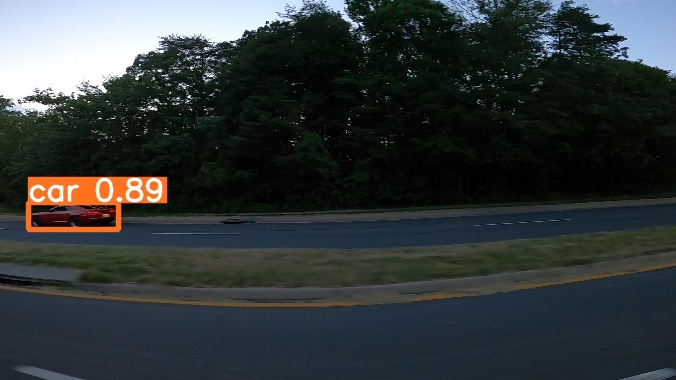

In [41]:

Image(filename=f'yolov5/runs/detect/exp2/{predicted_files[1]}')


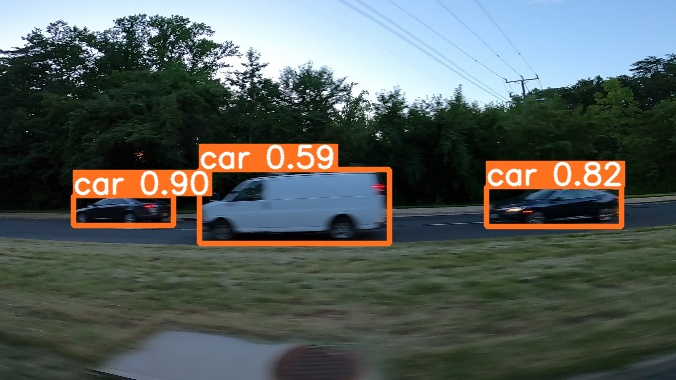

In [46]:
Image(filename=f'yolov5/runs/detect/exp2/{random.choice(predicted_files)}')

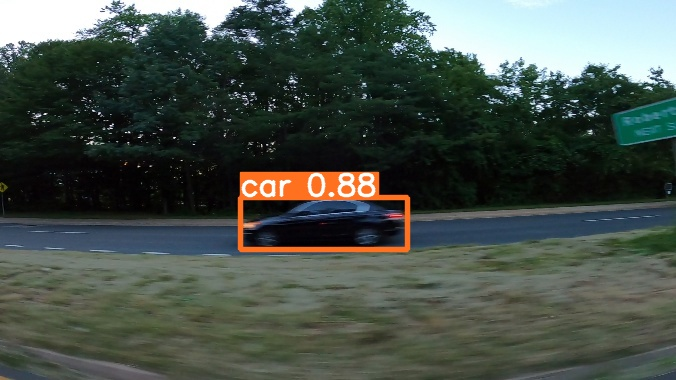

In [48]:
Image(filename=f'yolov5/runs/detect/exp2/{random.choice(predicted_files)}')